In [1]:
import time
import os
import gc
import psutil
import matplotlib.pyplot as plt



In [2]:

# =============================
# 1. Класс для сбора метрик
# =============================
class MetricsCollector:
    def __init__(self):
        self.start_time = time.time()
        self.token_times = []
        self.tokens = []

    def callback(self, token: int) -> bool:
        current_time = time.time()
        elapsed = current_time - self.start_time
        self.token_times.append(elapsed)
        self.tokens.append(token)
        # Прерываем генерацию, если встретились определённые токены (пример условия)
        return token in [151643, 151645]


In [3]:

# ==========================================
# 2. Тест для кастомной модели (с/без кэша)
# ==========================================
def test_custom(use_cache: bool):
    # Импорт кастомной модели (предполагается, что Processor реализован)
    from models.processor import Processor

    metrics_collector = MetricsCollector()
    messages = [{"role": "system", "content": "Расскажи про Олега Гербылева?"}]
    process = psutil.Process(os.getpid())
    mem_before = process.memory_info().rss

    start_time = time.time()
    # Инициализируем модель
    processor = Processor("Qwen/Qwen2-0.5B-Instruct")
    # Генерируем ответ с указанным флагом кэширования
    result = processor(messages, custom_callback=metrics_collector.callback, use_cache=use_cache, max_new_tokens = 500)
    end_time = time.time()

    mem_after = process.memory_info().rss
    elapsed = end_time - start_time
    mem_used = (mem_after - mem_before) / (1024 * 1024)  # в МБ
    tokens_count = len(metrics_collector.tokens)

    # Очистка памяти после работы модели
    del processor
    gc.collect()

    return {
        "model": "custom",
        "use_cache": use_cache,
        "time": elapsed,
        "memory": mem_used,
        "tokens": tokens_count,
        "response": result[0] if result else ""
    }


In [4]:

# ====================================================
# 3. Тест для оригинальной модели (Transformers)
# ====================================================
def test_transformers(use_cache: bool):
    from transformers import AutoModelForCausalLM, AutoTokenizer
    model_name = "Qwen/Qwen2-0.5B-Instruct"  # можно заменить на другую модель
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForCausalLM.from_pretrained(model_name)

    # Устанавливаем флаг кэширования (если модель поддерживает)
    model.config.use_cache = use_cache

    prompt = "Расскажи про Олега Гербылева?"
    input_ids = tokenizer.encode(prompt, return_tensors="pt")

    import psutil, os, time, gc
    process = psutil.Process(os.getpid())
    mem_before = process.memory_info().rss

    start_time = time.time()
    # Гарантированная генерация ровно 500 новых токенов (без учета токенов промпта)
    output_ids = model.generate(
        input_ids,
        min_new_tokens=500,
        max_new_tokens=500,
        do_sample=True  # или False – зависит от желаемого стиля генерации
    )
    end_time = time.time()

    mem_after = process.memory_info().rss
    elapsed = end_time - start_time
    output_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)
    tokens_count = len(tokenizer.tokenize(output_text))

    # Очистка памяти после работы модели
    del model
    gc.collect()

    return {
        "model": "original",
        "use_cache": use_cache,
        "time": elapsed,
        "memory": (mem_after - mem_before) / (1024 * 1024),  # в МБ
        "tokens": tokens_count,
        "response": output_text
    }


In [5]:

# ==========================================
# 4. Запуск 4-х тестов и сбор результатов
# ==========================================
results = []
results.append(test_custom(use_cache=True))
results.append(test_custom(use_cache=False))
results.append(test_transformers(use_cache=True))
# results.append(test_transformers(use_cache=False))

# Вывод результатов в консоль
for res in results:
    model_type = "Кастомная" if res["model"] == "custom" else "Оригинальная"
    cache_state = "с кэшем" if res["use_cache"] else "без кэша"
    print(f"{model_type} модель ({cache_state}):")
    print(f"  Время генерации: {res['time']:.2f} сек")
    print(f"  Потребление памяти: {res['memory']:.2f} МБ")
    print(f"  Количество токенов: {res['tokens']}")
    print(f"  Ответ: {res['response']}\n")


Fetching 10 files:   0%|          | 0/10 [00:00<?, ?it/s]

Fetching 10 files:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/290 [00:00<?, ?w/s]

Some parameters are on the meta device because they were offloaded to the cpu.
Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


Кастомная модель (с кэшем):
  Время генерации: 77.79 сек
  Потребление памяти: 498.76 МБ
  Количество токенов: 500
  Ответ: Олег Гербылев - это российский актер, известный своими актами в фильмах и телевизионных проектах. Он родился 14 марта 1972 года в Москве. Олег Гербылев начал свою карьеру в 1990 году в роли актера в фильме "Семь дней", который был выпущен в 1991 году. В 1992 году он сыграл главную роль в фильме "Семь дней", который стал одним из самых популярных фильмов в России.

В 1993 году Олег Гербылев начал свою карьеру в телевизионных проектах, где он играл главных ролей в таких сериалах как "Семь дней", "Семь дней: Время жизни", "Семь дней: Время жизни: Вторая половина", "Семь дней: Время жизни: Вторая половина: Вторая половина" и "Семь дней: Время жизни: Вторая половина: Вторая половина: Вторая половина".

Он также сыграл в нескольких других телевизионных проектах, таких как "Семь дней: Время жизни: Вторая половина: Вторая половина: Вторая половина: Вторая половина: Вторая

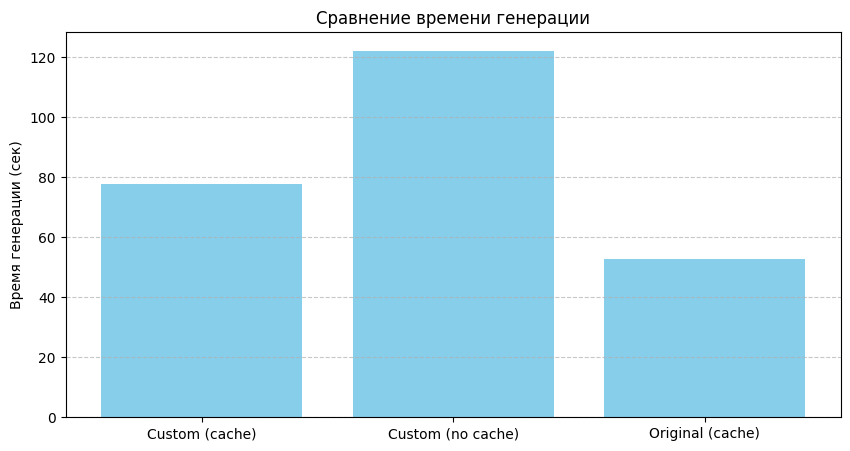

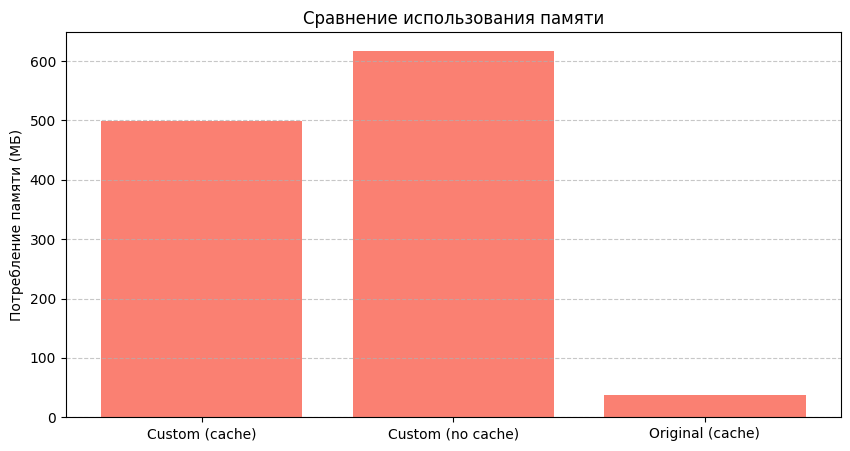

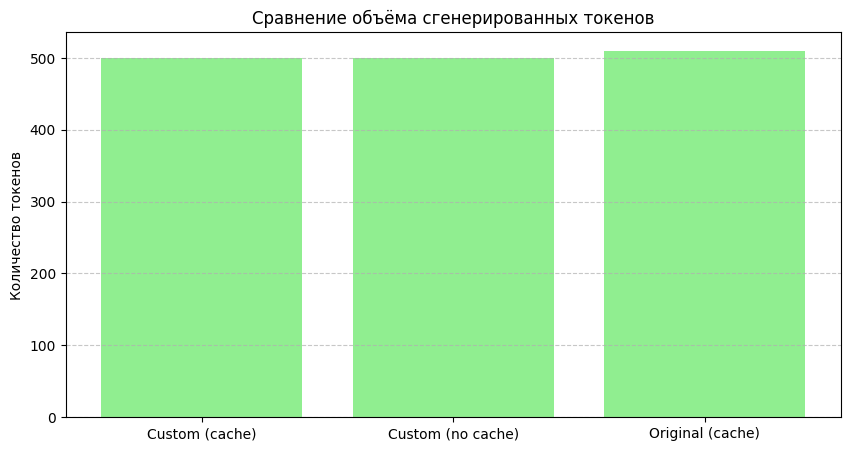

In [6]:

# ==========================================
# 5. Построение графиков для сравнения
# ==========================================
# Подготавливаем метки тестов
labels = [
    "Custom (cache)",
    "Custom (no cache)",
    "Original (cache)",
    # "Original (no cache)"
]
times = [res["time"] for res in results]
memories = [res["memory"] for res in results]
tokens = [res["tokens"] for res in results]

# График: Время генерации
plt.figure(figsize=(10, 5))
plt.bar(labels, times, color='skyblue')
plt.ylabel("Время генерации (сек)")
plt.title("Сравнение времени генерации")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# График: Потребление памяти
plt.figure(figsize=(10, 5))
plt.bar(labels, memories, color='salmon')
plt.ylabel("Потребление памяти (МБ)")
plt.title("Сравнение использования памяти")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# График: Количество токенов
plt.figure(figsize=(10, 5))
plt.bar(labels, tokens, color='lightgreen')
plt.ylabel("Количество токенов")
plt.title("Сравнение объёма сгенерированных токенов")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()